# Feature Engineering

"Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data."
Jason Brownlee, [Machine Learning Mastery](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)

1. Construct new features: Use domain knowledge, creating products of features, etc. 
1. Use recursive feature elimination to recursively remove attributes to meet the number of required features and then builds a model on those attributes that remain to see if you can you match or improve performance with a smaller subset.   
1. Use backward elimination to recursively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
1. Forward selection begins with an empty equation. Predictors are added one at a time beginning with the predictor with the highest correlation with the dependent variable. Variables of greater theoretical importance are entered first. Once in the equation, the variable remains there.
1. Compare several of these feature selection methods. Select the best approach with model selection.
1. To improve performance and/or understanding, subsample your data and redo your analysis for several samples.
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

import env
import wrangle
import split_scale

# acquire data and remove null values 
df = wrangle.wrangle_grades()

# split into train and test
train, test = split_scale.split_my_data(df)

For the feature engineering methods, we want to use the scaled data:

In [2]:
# scale data using standard scaler
scaler, train, test = split_scale.standard_scaler(train, test)

# to return to original values
# scaler, train, test = scaling.my_inv_transform(scaler, train, test)

X_train = train.drop(columns='final_grade')
y_train = train[['final_grade']]
X_test = test.drop(columns='final_grade')
y_test = test[['final_grade']]

## Filter Methods

- Goals:  You want to keep the attributes with highest correlation to the target variable and of those features, if two are highly correlated with each other, remove one of them. 
- Filter and take only the subset of the relevant features. 
- The model is built after selecting the features. 

### Correlation Thresholds

- The filtering can be done using correlation matrix with Pearson correlation.
- For example, if you had a real-estate dataset with 'Floor Area (Sq. Ft.)' and 'Floor Area (Sq. Meters)' as separate features, you can safely remove one of them.  Which one should you remove? Well, you'd first calculate all pair-wise correlations. Then, if the correlation between a pair of features is above a given threshold, you'd remove the one that has larger mean absolute correlation with other features.  

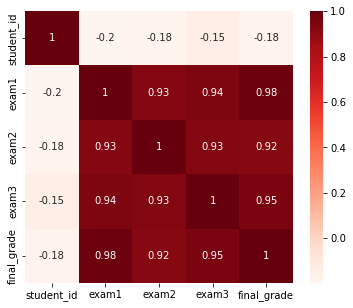

In [3]:
#Using Pearson Correlation
plt.figure(figsize=(6,5))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

To view just the correlations of each attribute with the target variable, and filter down to only those above a certain value:

In [4]:
#Correlation with output variable
cor_target = abs(cor["final_grade"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

exam1          0.984101
exam2          0.922598
exam3          0.950309
final_grade    1.000000
Name: final_grade, dtype: float64

Looking at the correlation of each of these variables, exam 1 is most correlated with final grade and all three exams are correlated with each other.  So using this method, we may decide to only use one exam or we may want to create new features, such as `exam2_delta = exam2 - exam1`

### Select K Best

- `SelectKBest` removes all but the highest scoring features
- Scores are the test statistic for the chosen function or test (Chi-squared, F-regression, etc.)

In [5]:
from sklearn.feature_selection import SelectKBest

#### Using f-regression

Linear model for testing the individual effect of each of many regressors. This is a scoring function to be used in a feature selection procedure, not a free standing feature selection procedure.

This is done in 2 steps:

1. The correlation between each regressor and the target is computed.  
2. It is converted to an F score then to a p-value.  

In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

f_selector = SelectKBest(f_regression, k=2)

f_selector.fit(X_train, y_train)

f_support = f_selector.get_support()
f_feature = X_train.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

2 selected features
['exam1', 'exam3']


## Wrapper Methods

- A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. 
- You feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. 
- This is an iterative and computationally expensive process but it is more accurate than the filter method.
- Methods include: Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. 

### Backward Elimination using OLS

- We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
- The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.
- We will first run one iteration here just to get an idea of the concept and then we will run the same code in a loop, which will give the final set of features. 
- Ordinary Least Squares (OLS) can be used to do this.

In [7]:
import statsmodels.api as sm

# create the OLS object:
ols_model = sm.OLS(y_train, X_train)

# fit the model:
fit = ols_model.fit()

# summarize:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            final_grade   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              711.7
Date:                Thu, 03 Feb 2022   Prob (F-statistic):                    5.97e-60
Time:                        14:13:18   Log-Likelihood:                          32.358
No. Observations:                  81   AIC:                                     -56.72
Df Residuals:                      77   BIC:                                     -47.14
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
student_id     0.0041      0.019      0.217      0.829      -0.034       0.042
exam1          0.8038      0.060     13.288      0.000       0.683       0.924
exam2         -0.0366      0.057     -0.642      0.523      -0.150       0.077
exam3          0.2285      0.063      3.624      0.001       0.103       0.354
==============================================================================
Omnibus:                        3.132   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                2.463
Skew:                           0.291   Prob(JB):                        0.292
Kurtosis:                       2.374   Cond. No.                         7.19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at the summary above, we see that the p-value for exam 2 is very high, while exams 1 and 3 are minimal.

Below, we will use OLS for backwards elimation.

In [8]:
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['exam1', 'exam3']


Based on this above, we will want to keep only exam1 and exam3, as we saw in the summary table.

### Recursive Feature Elimination (RFE) 

- Recursively removes attributes and then builds a model on those attributes that remain. 
- It uses accuracy metric to rank the feature according to their importance. 
- The RFE method takes the model to be used and the number of required features as input. 
- It returns the ranking of all the variables, 1 being most important, along with its support, True being relevant feature and False being irrelevant feature.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

model = LinearRegression()

#Initializing RFE model, with parameter to select top 2 features. 
rfe = RFE(model, n_features_to_select=2)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)

print(rfe.support_)
print(rfe.ranking_)

[False  True False  True]
[3 1 2 1]


- Here we took LinearRegression model with 2 features and RFE gave feature ranking as above, but the selection of number ‘2’ was random. 
- Now we need to find the optimum number of features, for which the accuracy is the highest. 
- We do that by using loop starting with 1 feature and going up to 3. We then take the one for which the accuracy is highest.

In [10]:
number_of_features_list=np.arange(1,3)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 2
Score with 2 features: 0.965926


- As seen from above code, the optimum number of features is 2. 
- We now feed 2 as number of features to RFE and get the final set of features given by RFE method, as follows:

In [11]:
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, n_features_to_select=2)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['exam1', 'exam3'], dtype='object')


## Embedded Methods

- Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration.
- Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
- E.g. Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient by making it 0. Hence the features with coefficient = 0 are removed and the rest are taken.
- Other regularization algorithms: Elastic Net, Ridge Regression, and Regularized Regression.


In [12]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_train, y_train)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X_train.columns)


print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Best alpha using built-in LassoCV: 0.013949
Best score using built-in LassoCV: 0.973301
Lasso picked 2 variables and eliminated the other 2 variables


The higher the value of $\alpha$ the fewer the features have non-zero values, the more features that have zero-values. 

Text(0.5, 1.0, 'Feature importance using Lasso Model')

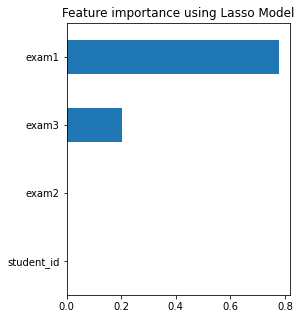

In [13]:
imp_coef = coef.sort_values()

import matplotlib

matplotlib.rcParams['figure.figsize'] = (4.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

## Linear Dimensionality Reduction

### Principal component analysis (PCA) 

- Unsupervised algorithm
- Creates linear combinations of the original features
- The new features are orthogonal, therefore, uncorrelated. 
- They are ranked in order of their "explained variance." 
- PC1 explains the most variance in your dataset, PC2 explains the second-most variance, etc.
- You might decide to keep only as many principal components as needed to reach a cumulative explained variance of 90%.
- Always normalize your dataset before performing PCA because the transformation is dependent on scale.
- Versatile, fast, simple to implement
- There exist several variations and extensions (i.e. kernel PCA, sparse PCA, etc.) to tackle specific roadblocks.
- The new principal components or features are not interpretable
- `sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver=’auto’, tol=0.0, iterated_power=’auto’, random_state=None)`

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, copy=True, whiten=False, svd_solver='auto', random_state=123)
pca.fit(X_train)
X = pca.transform(X_train)
print(pca.n_components_)
print(len(X))
print(pca.explained_variance_ratio_)
print(X[0:5])

1
81
[0.72956108]
[[-1.4843675 ]
 [-1.14217214]
 [-0.04796074]
 [-0.9912816 ]
 [-2.32558288]]


## Summary

- the optimum number of features is 2
- exam1 and exam3 were the top performing features
- In your exercises, you will use RFE, recursive feature elimination, to write UDF's to identify ideal number of features, find what those are, and create new train and test dataframes with those two features. 

## Exercises

Our scenario continues:  
As a customer analyst, I want to know who has spent the most money with us over their lifetime. I have monthly charges and tenure, so I think I will be able to use those two attributes as features to estimate total_charges. I need to do this within an average of $5.00 per customer. 

1. Write a function, `select_kbest_freg()` that takes X_train, y_train and k as input (X_train and y_train should not be scaled!) and returns a list of the top k features. 
2. Write a function, `select_kbest_freg()` that takes X_train, y_train (scaled) and k as input and returns a list of the top k features. 
3. Write a function, `ols_backware_elimination()` that takes X_train and y_train (scaled) as input and returns selected features based on the ols backwards elimination method. 
4. Write a function, `lasso_cv_coef()` that takes X_train and y_train as input and returns the coefficients for each feature, along with a plot of the features and their weights. 
5. Write 3 functions, the first computes the number of optimum features (n) using rfe, the second takes n as input and returns the top n features, and the third takes the list of the top n features as input and returns a new X_train and X_test dataframe with those top features , `recursive_feature_elimination()` that computes the optimum number of features (n) and returns the top n features. 